In [1]:
# Step 1: Import Necessary Libraries
import os
import time
import math
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models
import torchvision.transforms as T
import matplotlib.cm as cm
from tqdm import tqdm

In [2]:
# Step 2: Define Utility Functions
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [3]:
#Set Device and Model Path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model_path = 'bisenet_model.pth'

cuda


In [5]:
#Specify Paths and Configuration
image_path = "/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic"
mask_path = "/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask"

In [6]:
#Load and Preprocess Data for Visualization
names2 = ['X_mask_190','X_mask_191','X_mask_192']
names = ['X_seismic_190','X_seismic_191','X_seismic_192']
images = [Image.open(os.path.join(image_path, name+'.png')) for name in names]
masks = [Image.open(os.path.join(mask_path, name+'.png')) for name in names2]

transforms = T.Compose([T.Grayscale(), T.ToTensor()])
x = torch.stack([transforms(image) for image in images])
y = torch.stack([transforms(mask) for mask in masks])

In [7]:
x.shape

torch.Size([3, 1, 369, 496])

In [8]:
y.shape

torch.Size([3, 1, 369, 496])

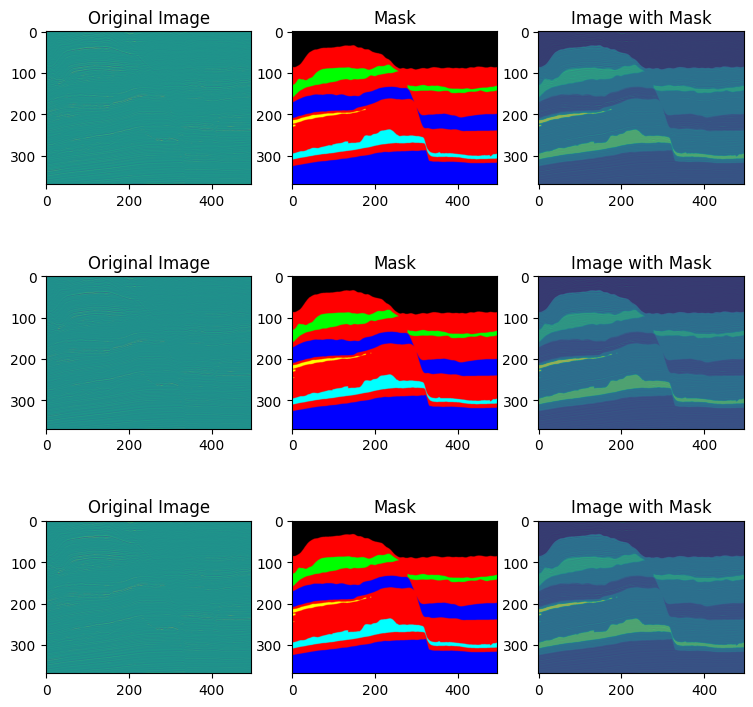

In [9]:
# Step 6: Visualize Sample Data
fig = plt.figure(figsize=(9, 9))
num_images = len(images)
for i in range(num_images):
    ax = fig.add_subplot(num_images, 3, i*3+1)
    ax.imshow(images[i])
    ax.set_title("Original Image")

    ax = fig.add_subplot(num_images, 3, i*3+2)
    ax.imshow(masks[i])
    ax.set_title("Mask")

    ax = fig.add_subplot(num_images, 3, i*3+3)
    ax.imshow(x[i].squeeze())
    ax.imshow(y[i].squeeze(), alpha=0.5)
    ax.set_title("Image with Mask")

plt.show()

In [10]:
# Step 7: Define Custom Dataset Class
class SegmentDataset(Dataset):

    color_encoding = [
                ('a', (0, 0, 0)),    # Black
                ('b', (255, 0, 0)),  # Red
                ('c', (0, 255, 0)),  # Green
                ('d', (0, 0, 255)),  # Blue
                ('e', (255, 255, 0)),  # Yellow
                ('f', (0, 255, 255))   # Cyan
    ]

    def __init__(self, image_paths, mask_paths, num_classes=7):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.num_classes=num_classes

#         self.transforms = T.Compose([T.Grayscale(), T.ToTensor()])
        self.transforms = T.Compose([T.ToTensor()])

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = image.convert('RGB')
        
        image = self.transforms(image)
        resized_image = T.Resize((104, 104))(image)
        
        mask = Image.open(self.mask_paths[idx])
        mask = mask.convert('RGB')
        mask = np.array(mask)
        mask = self.label_for_cross_entropy(mask)
        mask = Image.fromarray(mask)
        resized_mask = T.Resize((104, 104))(mask)
        resized_mask = np.array(resized_mask)
        
        return resized_image, torch.from_numpy(resized_mask).long()

    def label_for_cross_entropy(self, label):
        """
            Convert label image to matrix classes for apply cross entropy loss.
            Return semantic index, label in enumemap of H x W x class
        """
        semantic_map = np.zeros(label.shape[:-1])
        # Fill all value with class 13 - default for all pixels
        semantic_map.fill(self.num_classes - 1)
        # Fill the pixel with correct class

        for class_index, color_info in enumerate(self.color_encoding):
            color = color_info[1]
            equality = np.equal(label, color)
            class_map = np.all(equality, axis=-1)
            semantic_map[class_map] = class_index
        return semantic_map

    def __len__(self):
        return len(self.mask_paths)

In [11]:
import os
from sklearn.model_selection import train_test_split

# Paths to your image and mask folders
image_folder = "/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic"
mask_folder = "/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask"

# List all files in the image and mask folders
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith('.png')]
mask_files = [os.path.join(mask_folder, file).replace('seismic', 'mask') for file in image_files]

# Split files into training and validation sets
image_train, image_val, mask_train, mask_val = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

# Verify the lengths of the training and validation sets
print(f"Number of training samples: {len(image_train)}")
print(f"Number of validation samples: {len(image_val)}")

# Optionally, you can create separate lists for training and validation images and masks
training_image_paths = image_train
training_mask_paths = mask_train
val_image_paths = image_val
val_mask_paths = mask_val

/home/sang/Desktop/venv39/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Number of training samples: 625
Number of validation samples: 157


In [12]:
image_train

['/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_167.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_188.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_75.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_262.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_239.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_364.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_261.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_438.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_745.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_56.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_218.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_208.png',
 '/home/sang/Documents/Dataset/SEG_2020/ex

In [13]:
training_mask_paths

['/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_167.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_188.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_75.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_262.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_239.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_364.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_261.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_438.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_745.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_56.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_218.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_208.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_332.png',
 '/home/sang/Documents/Dataset/SEG_2020/

In [14]:
# Step 8: Initialize Dataset
train_dataset = SegmentDataset(training_image_paths, training_mask_paths)
# Step 5: Validation Dataset
val_dataset = SegmentDataset(val_image_paths, val_mask_paths)

In [15]:
# Step 6: Validation DataLoader
BATCH_SIZE = 64
dataloader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

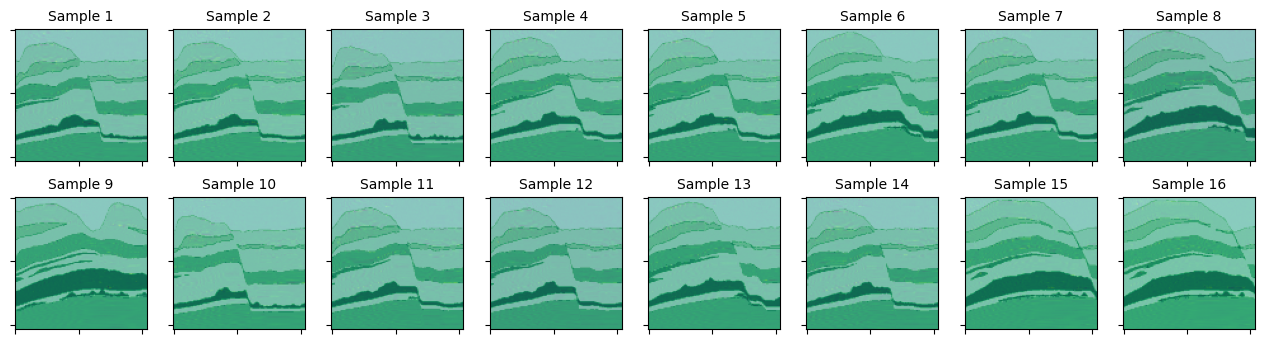

In [16]:

# Step 9: Visualize More Data from Dataset
max_images = 16
grid_width = 8
grid_height = max_images // grid_width
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width * 2, grid_height * 2))

for i in range(max_images):
    image, mask = train_dataset[i]
    image = np.transpose(image, (1, 2, 0))
    ax = axs[i // grid_width, i % grid_width]
    ax.imshow(image.squeeze(), cmap="Greys")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Greens")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(f"Sample {i+1}", fontsize=10)

# # Add color bar to indicate mask colors
# cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
# cbar = plt.colorbar(cm.ScalarMappable(cmap='Greens'), cax=cax)
# cbar.set_label('Mask Colors')

plt.show()

In [17]:
# Step 10: Define Model Architecture

"""
This class defines a convolutional block, which consists of a convolutional layer followed by batch normalization.
"""
class ConvBlock(nn.Module):
    def __init__(self, in_channels, filters, size, stride=1, activation=True):
        super(ConvBlock, self).__init__()
        self.activation = activation
        # Convolutional layer with specified parameters
        self.conv = nn.Conv2d(in_channels, filters, size, stride=stride, padding=size // 2)
        # Batch normalization layer
        self.norm = nn.BatchNorm2d(filters)

    def forward(self, x):
        # Forward pass through the convolutional block
        x = self.conv(x)  # Apply convolution
        x = self.norm(x)  # Apply batch normalization
        if self.activation:
            return F.relu(x)  # Apply ReLU activation if specified
        else:
            return x


"""
This class defines a residual block, which consists of two convolutional blocks and optional residual connections.
"""
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, filters, size=3):
        super(ResidualBlock, self).__init__()
        self.norm = nn.BatchNorm2d(in_channels)
        # First convolutional block
        self.conv1 = ConvBlock(in_channels, filters, size)
        # Second convolutional block with no activation
        self.conv2 = ConvBlock(filters, filters, size, activation=False)

    def forward(self, x):
        residual = x  # Save input as residual
        x = F.relu(x)  # Apply ReLU activation
        x = self.norm(x)  # Apply batch normalization
        x = self.conv1(x)  # First convolutional block
        x = self.conv2(x)  # Second convolutional block
        # Optionally add residual connection
        # x += residual  # Uncomment if you want to use residual connections
        return x


"""
This class defines a deconvolutional block, which consists of a transposed convolutional layer.
"""
class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2):
        super(DeconvBlock, self).__init__()
        # Transposed convolutional layer
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride)

    def forward(self, x1, x2):
        xd = self.deconv(x1)  # Apply transposed convolution
        # Concatenate feature maps from the transposed convolution with feature maps from a previous stage
        x = torch.cat([xd, x2], dim=1)
        return x
    
"""
Defines ChannelAttention class
"""
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction_rate=16):
        super(ChannelAttention, self).__init__()
        self.squeeze = nn.ModuleList([
            nn.AdaptiveAvgPool2d(1),
            nn.AdaptiveMaxPool2d(1)
        ])
        
        self.excitation = nn.Sequential(
            nn.Conv2d(in_channels=channels,
                      out_channels=channels // reduction_rate,
                      kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=channels // reduction_rate,
                      out_channels=channels,
                      kernel_size=1)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # perform squeeze with independent Pooling
        avg_feat = self.squeeze[0](x)
        max_feat = self.squeeze[1](x)
        # perform excitation with the same excitation sub-net
        avg_out = self.excitation(avg_feat)
        max_out = self.excitation(max_feat)
        # attention
        attention = self.sigmoid(avg_out + max_out)
        return attention * x

In [18]:
# Step 11: Define U-Net Model
class UnetModel(nn.Module):

    def __init__(self, filters=16, dropout=0.5, num_classes=7, in_channel=1):
        super(UnetModel, self).__init__()
        # Define encoder layers
        self.num_classes=num_classes
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, filters, 3, padding=1),
            ResidualBlock(filters, filters),
            ResidualBlock(filters, filters),
            nn.ReLU()
        )
        
        # create channel attention
        self.attention_1 = ChannelAttention(filters)
        
        self.conv2 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout/2),
            nn.Conv2d(filters, filters * 2, 3, padding=1),
            ResidualBlock(filters * 2, filters * 2),
            ResidualBlock(filters * 2, filters * 2),
            nn.ReLU()
        )
        
        # create channel attention
        self.attention_2 = ChannelAttention(filters * 2)
        
        self.conv3 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 2, filters * 4, 3, padding=1),
            ResidualBlock(filters * 4, filters * 4),
            ResidualBlock(filters * 4, filters * 4),
            nn.ReLU()
        )
        
        # create channel attention
        self.attention_3 = ChannelAttention(filters * 4)
        
        self.conv4 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 4, filters * 8, 3, padding=1),
            ResidualBlock(filters * 8, filters * 8),
            ResidualBlock(filters * 8, filters * 8),
            nn.ReLU()
        )
        
        # create channel attention
        self.attention_4 = ChannelAttention(filters * 8)
        
        # Define middle layers
        self.middle = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 8, filters * 16, 3, padding=3//2),
            ResidualBlock(filters * 16, filters * 16),
            ResidualBlock(filters * 16, filters * 16),
            nn.ReLU()
        )
        
        self.attention_5 = ChannelAttention(filters * 16)
        
        # Define decoder layers
        self.deconv4 = DeconvBlock(filters * 16, filters * 8, 3)
        self.upconv4 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 16, filters * 8, 3, padding=1),
            ResidualBlock(filters * 8, filters * 8),
            ResidualBlock(filters * 8, filters * 8),
            nn.ReLU()
        )
        
        self.attention_6 = ChannelAttention(filters * 8)
        
        self.deconv3 = DeconvBlock(filters * 8, filters * 4, 2)
        self.upconv3 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 8, filters * 4, 3, padding=1),
            ResidualBlock(filters * 4, filters * 4),
            ResidualBlock(filters * 4, filters * 4),
            nn.ReLU()
        )
        
        self.attention_7 = ChannelAttention(filters * 4)
        
        self.deconv2 = DeconvBlock(filters * 4, filters * 2, 2)
        self.upconv2 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 4, filters * 2, 3, padding=1),
            ResidualBlock(filters * 2, filters * 2),
            ResidualBlock(filters * 2, filters * 2),
            nn.ReLU()
        )
        
        self.attention_8 = ChannelAttention(filters * 2)
        
        self.deconv1 = DeconvBlock(filters * 2, filters, 2)
        self.upconv1 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 2, filters, 3, padding=1),
            ResidualBlock(filters, filters),
            ResidualBlock(filters, filters),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Conv2d(filters, num_classes, 3, padding=1)
        )

    def forward(self, x):
        conv1 = self.conv1(x) 
        conv2 = self.conv2(conv1) 
        conv3 = self.conv3(conv2) 
        conv4 = self.conv4(conv3) 
        x = self.middle(conv4) 
        x = self.deconv4(x, conv4)
        x = self.upconv4(x)
        x = self.deconv3(x, conv3)
        x = self.upconv3(x)
        x = self.deconv2(x, conv2)
        x = self.upconv2(x)
        x = self.deconv1(x, conv1)
        x = self.upconv1(x)
        return x

In [19]:
# Step 14.1: Define Helper Functions

def reverse_one_hot(image):
    # Convert output of model to predicted class
    image = image.permute(0, 2, 3, 1)
    x = torch.argmax(image, dim=-1)
    return x

def compute_accuracy(pred, label):
    pred = pred.flatten()
    label = label.flatten()
    total = len(label)
    count = 0.0
    for i in range(total):
        if pred[i] == label[i]:
            count = count + 1.0
    return float(count) / float(total)

In [20]:
# Step 14.2: Get IoU Score
def fast_hist(a, b, n):
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

def per_class_iu(hist):
    epsilon = 1e-5
    return (np.diag(hist) + epsilon) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)

In [21]:
# Step 15: Get validate function
NUM_CLASSES=7
def val(model, dataloader):
    accuracy_arr = []

    hist = np.zeros((NUM_CLASSES, NUM_CLASSES))

    with torch.no_grad():
        model.eval()
        print('Starting validate')
        
        val_loss_record = []
        
        for i, (val_data, val_label) in enumerate(dataloader):
            val_data = val_data.cuda()
            val_label_cuda = val_label.cuda()
            # The output of model is (1, num_classes, W, H) => (num_classes, W, H)
            val_output = model(val_data)
            
            val_loss1 = loss_func(val_output, val_label_cuda)

            # Combine 3 loss
            val_loss = val_loss1
            
            val_output = val_output.squeeze()

            # Convert the (num_classes, W, H) => (W, H) with one hot decoder
            val_output = reverse_one_hot(val_output)
            val_output = np.array(val_output.cpu())
            # Process label. Convert to (W, H) image
            val_label = val_label.squeeze()
            val_label = np.array(val_label.cpu())
            # Compute accuracy and iou
            accuracy = compute_accuracy(val_output, val_label)
            hist += fast_hist(val_label.flatten(), val_output.flatten(), NUM_CLASSES)
            # Append for calculate
            accuracy_arr.append(accuracy)
            val_loss_record.append(loss.item())
            
        val_loss_mean = np.mean(val_loss_record)
        miou_list = per_class_iu(hist)[:-1]
        mean_accuracy, mean_iou = np.mean(accuracy_arr), np.mean(miou_list)
        print('Mean validate loss: {} Mean validate IoU: {}'.format(val_loss_mean, mean_iou))
        return mean_accuracy, mean_iou, val_loss_mean

In [22]:
# Step 16.1: Create DataLoader for Training Dataset
dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
steps = len(train_dataset) // BATCH_SIZE
print(steps, "steps per epoch")

9 steps per epoch


In [23]:
# Step 16.3: Define model and training function, hyperparameters
EPOCHS = 200
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
CHECKPOINT_STEP = 2
VALIDATE_STEP = 1

model = UnetModel(num_classes=NUM_CLASSES, in_channel=3).to(device)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

loss_func = torch.nn.CrossEntropyLoss()

In [24]:
# Step 16.2: Model Training

# Loop for training
torch.cuda.empty_cache()

max_miou = 0
max_miou_epoch = 0

train_iou_hist = []
val_iou_hist = []

train_loss_hist = []
val_loss_hist = []

for epoch in range(EPOCHS):
    model.train()
    tq = tqdm(total=len(dataloader_train) * BATCH_SIZE)
    tq.set_description('Epoch {}/{}'.format(epoch + 1, EPOCHS))
    
    hist = np.zeros((NUM_CLASSES, NUM_CLASSES))
    loss_record = []

    for i, (data, label) in enumerate(dataloader_train):
        data = data.cuda()
        label = label.cuda()
        output = model(data)
        loss = loss_func(output, label)
        
        tq.update(BATCH_SIZE)
        tq.set_postfix(loss='%.6f' % loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_record.append(loss.item())
        
        output = reverse_one_hot(output)
        output = np.array(output.cpu())
        
        hist += fast_hist(label.flatten().detach().cpu().numpy(), output.flatten(), NUM_CLASSES)
        
    tq.close()
    loss_train_mean = np.mean(loss_record)
    miou_list = per_class_iu(hist)[:-1]
    mean_iou = np.mean(miou_list)
    
    train_iou_hist = train_iou_hist + [mean_iou]
    train_loss_hist = train_loss_hist + [loss_train_mean]
    
    print('loss for train : %f' % (loss_train_mean))
    print('IoU for train : %f' % (mean_iou))
    
    # Save checkpoint
    if epoch % CHECKPOINT_STEP == 0:
        torch.save(model.state_dict(), 'lastest_model.pth')

    # Validate save best model
    # Save checkpoint
    if epoch % VALIDATE_STEP == 0:
        _, mean_iou, val_loss = val(model, dataloader_val)
        val_iou_hist = val_iou_hist + [mean_iou]
        val_loss_hist = val_loss_hist + [val_loss]
        if mean_iou > max_miou:
            max_miou = mean_iou
            max_miou_epoch = epoch + 1
            print('Save best model with mIoU = {}'.format(mean_iou))
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            print('Best mIoU: {} at epoch {}'.format(max_miou, max_miou_epoch))

Epoch 1/200: 100%|█████████████████████████████████████████████████████████| 576/576 [00:53<00:00, 10.80it/s, loss=1.508772]


loss for train : 1.734980
IoU for train : 0.147767
Starting validate
Mean validate loss: 1.5087724924087524 Mean validate IoU: 0.06271597187268324
Save best model with mIoU = 0.06271597187268324


Epoch 2/200: 100%|█████████████████████████████████████████████████████████| 576/576 [00:44<00:00, 12.97it/s, loss=1.195435]


loss for train : 1.325849
IoU for train : 0.243496
Starting validate
Mean validate loss: 1.195434808731079 Mean validate IoU: 0.07503679877159836
Save best model with mIoU = 0.07503679877159836


Epoch 3/200: 100%|█████████████████████████████████████████████████████████| 576/576 [00:39<00:00, 14.67it/s, loss=0.994009]


loss for train : 1.068123
IoU for train : 0.310689
Starting validate
Mean validate loss: 0.9940093159675598 Mean validate IoU: 0.08908854338214516
Save best model with mIoU = 0.08908854338214516


Epoch 4/200: 100%|█████████████████████████████████████████████████████████| 576/576 [00:41<00:00, 13.97it/s, loss=0.894329]


loss for train : 0.939261
IoU for train : 0.333810
Starting validate
Mean validate loss: 0.8943288922309875 Mean validate IoU: 0.09751657602186938
Save best model with mIoU = 0.09751657602186938


Epoch 5/200: 100%|█████████████████████████████████████████████████████████| 576/576 [00:48<00:00, 11.81it/s, loss=0.786104]


loss for train : 0.850467
IoU for train : 0.354233
Starting validate
Mean validate loss: 0.7861036658287048 Mean validate IoU: 0.10471567374209172
Save best model with mIoU = 0.10471567374209172


Epoch 6/200: 100%|█████████████████████████████████████████████████████████| 576/576 [00:47<00:00, 12.23it/s, loss=0.689558]


loss for train : 0.730207
IoU for train : 0.390334
Starting validate
Mean validate loss: 0.689558207988739 Mean validate IoU: 0.1754713118745199
Save best model with mIoU = 0.1754713118745199


Epoch 7/200: 100%|█████████████████████████████████████████████████████████| 576/576 [00:39<00:00, 14.48it/s, loss=0.660229]


loss for train : 0.683401
IoU for train : 0.403619
Starting validate
Mean validate loss: 0.6602287292480469 Mean validate IoU: 0.2736427134604009
Save best model with mIoU = 0.2736427134604009


Epoch 8/200: 100%|█████████████████████████████████████████████████████████| 576/576 [00:40<00:00, 14.06it/s, loss=0.607360]


loss for train : 0.627938
IoU for train : 0.420859
Starting validate
Mean validate loss: 0.6073599457740784 Mean validate IoU: 0.3947089956817265
Save best model with mIoU = 0.3947089956817265


Epoch 9/200: 100%|█████████████████████████████████████████████████████████| 576/576 [00:43<00:00, 13.27it/s, loss=0.530568]


loss for train : 0.562408
IoU for train : 0.460721
Starting validate
Mean validate loss: 0.5305683016777039 Mean validate IoU: 0.3621379587264808
Best mIoU: 0.3947089956817265 at epoch 8


Epoch 10/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:34<00:00, 16.74it/s, loss=0.486170]


loss for train : 0.499748
IoU for train : 0.561050
Starting validate
Mean validate loss: 0.4861700236797333 Mean validate IoU: 0.3786489876826697
Best mIoU: 0.3947089956817265 at epoch 8


Epoch 11/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:20<00:00, 27.72it/s, loss=0.441155]


loss for train : 0.460234
IoU for train : 0.597847
Starting validate
Mean validate loss: 0.4411548972129822 Mean validate IoU: 0.5493769226897623
Save best model with mIoU = 0.5493769226897623


Epoch 12/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:20<00:00, 28.71it/s, loss=0.396962]


loss for train : 0.424224
IoU for train : 0.610238
Starting validate
Mean validate loss: 0.3969617187976837 Mean validate IoU: 0.5627886950764115
Save best model with mIoU = 0.5627886950764115


Epoch 13/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:20<00:00, 27.64it/s, loss=0.396088]


loss for train : 0.410981
IoU for train : 0.612990
Starting validate
Mean validate loss: 0.3960877060890198 Mean validate IoU: 0.5711980366785497
Save best model with mIoU = 0.5711980366785497


Epoch 14/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:30<00:00, 18.72it/s, loss=0.371193]


loss for train : 0.388904
IoU for train : 0.623208
Starting validate
Mean validate loss: 0.3711925148963928 Mean validate IoU: 0.45025911243855515
Best mIoU: 0.5711980366785497 at epoch 13


Epoch 15/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:21<00:00, 26.76it/s, loss=0.359585]


loss for train : 0.371885
IoU for train : 0.627868
Starting validate
Mean validate loss: 0.3595854341983795 Mean validate IoU: 0.5875716262161902
Save best model with mIoU = 0.5875716262161902


Epoch 16/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:28<00:00, 19.94it/s, loss=0.327655]


loss for train : 0.353529
IoU for train : 0.634112
Starting validate
Mean validate loss: 0.3276553153991699 Mean validate IoU: 0.6316604443689652
Save best model with mIoU = 0.6316604443689652


Epoch 17/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:30<00:00, 18.77it/s, loss=0.348022]


loss for train : 0.329154
IoU for train : 0.645762
Starting validate
Mean validate loss: 0.3480224907398224 Mean validate IoU: 0.6435854333659544
Save best model with mIoU = 0.6435854333659544


Epoch 18/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:32<00:00, 17.49it/s, loss=0.322765]


loss for train : 0.323225
IoU for train : 0.647592
Starting validate
Mean validate loss: 0.3227653205394745 Mean validate IoU: 0.6459101755029512
Save best model with mIoU = 0.6459101755029512


Epoch 19/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:29<00:00, 19.74it/s, loss=0.311254]


loss for train : 0.328918
IoU for train : 0.640484
Starting validate
Mean validate loss: 0.31125369668006897 Mean validate IoU: 0.6556849236972534
Save best model with mIoU = 0.6556849236972534


Epoch 20/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:30<00:00, 18.79it/s, loss=0.294399]


loss for train : 0.310725
IoU for train : 0.649155
Starting validate
Mean validate loss: 0.2943994402885437 Mean validate IoU: 0.65736141183376
Save best model with mIoU = 0.65736141183376


Epoch 21/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:29<00:00, 19.31it/s, loss=0.310001]


loss for train : 0.321327
IoU for train : 0.643284
Starting validate
Mean validate loss: 0.31000128388404846 Mean validate IoU: 0.6507573485912085
Best mIoU: 0.65736141183376 at epoch 20


Epoch 22/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:29<00:00, 19.84it/s, loss=0.293581]


loss for train : 0.306337
IoU for train : 0.650256
Starting validate
Mean validate loss: 0.29358091950416565 Mean validate IoU: 0.6484885573142739
Best mIoU: 0.65736141183376 at epoch 20


Epoch 23/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:29<00:00, 19.71it/s, loss=0.295842]


loss for train : 0.302640
IoU for train : 0.649216
Starting validate
Mean validate loss: 0.2958420217037201 Mean validate IoU: 0.666531072053779
Save best model with mIoU = 0.666531072053779


Epoch 24/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:28<00:00, 20.31it/s, loss=0.290257]


loss for train : 0.288820
IoU for train : 0.656491
Starting validate
Mean validate loss: 0.29025721549987793 Mean validate IoU: 0.64609588639814
Best mIoU: 0.666531072053779 at epoch 23


Epoch 25/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:28<00:00, 20.05it/s, loss=0.275436]


loss for train : 0.283985
IoU for train : 0.656892
Starting validate
Mean validate loss: 0.27543580532073975 Mean validate IoU: 0.6645620184897462
Best mIoU: 0.666531072053779 at epoch 23


Epoch 26/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:59<00:00,  9.70it/s, loss=0.265642]


loss for train : 0.276840
IoU for train : 0.661035
Starting validate
Mean validate loss: 0.2656417489051819 Mean validate IoU: 0.6663141812600986
Best mIoU: 0.666531072053779 at epoch 23


Epoch 27/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:30<00:00, 18.86it/s, loss=0.279959]


loss for train : 0.282619
IoU for train : 0.657361
Starting validate
Mean validate loss: 0.279958575963974 Mean validate IoU: 0.6602118415485089
Best mIoU: 0.666531072053779 at epoch 23


Epoch 28/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:30<00:00, 18.84it/s, loss=0.277504]


loss for train : 0.279833
IoU for train : 0.661861
Starting validate
Mean validate loss: 0.2775043547153473 Mean validate IoU: 0.6621323345568527
Best mIoU: 0.666531072053779 at epoch 23


Epoch 29/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:31<00:00, 18.39it/s, loss=0.261288]


loss for train : 0.271752
IoU for train : 0.669329
Starting validate
Mean validate loss: 0.26128849387168884 Mean validate IoU: 0.6815641824023082
Save best model with mIoU = 0.6815641824023082


Epoch 30/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:28<00:00, 20.34it/s, loss=0.255679]


loss for train : 0.271827
IoU for train : 0.674179
Starting validate
Mean validate loss: 0.25567853450775146 Mean validate IoU: 0.682282547232726
Save best model with mIoU = 0.682282547232726


Epoch 31/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:27<00:00, 21.15it/s, loss=0.300143]


loss for train : 0.269047
IoU for train : 0.682675
Starting validate
Mean validate loss: 0.30014339089393616 Mean validate IoU: 0.7044312218044805
Save best model with mIoU = 0.7044312218044805


Epoch 32/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:28<00:00, 20.00it/s, loss=0.250141]


loss for train : 0.257405
IoU for train : 0.694639
Starting validate
Mean validate loss: 0.25014105439186096 Mean validate IoU: 0.7120328024592775
Save best model with mIoU = 0.7120328024592775


Epoch 33/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:28<00:00, 20.51it/s, loss=0.247530]


loss for train : 0.251291
IoU for train : 0.703997
Starting validate
Mean validate loss: 0.2475302666425705 Mean validate IoU: 0.7119372499914944
Best mIoU: 0.7120328024592775 at epoch 32


Epoch 34/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:27<00:00, 21.23it/s, loss=0.284063]


loss for train : 0.254808
IoU for train : 0.703652
Starting validate
Mean validate loss: 0.2840631604194641 Mean validate IoU: 0.706014333737721
Best mIoU: 0.7120328024592775 at epoch 32


Epoch 35/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:26<00:00, 21.75it/s, loss=0.251385]


loss for train : 0.252542
IoU for train : 0.707695
Starting validate
Mean validate loss: 0.2513848841190338 Mean validate IoU: 0.6996572630290642
Best mIoU: 0.7120328024592775 at epoch 32


Epoch 36/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:28<00:00, 20.27it/s, loss=0.235850]


loss for train : 0.248942
IoU for train : 0.711618
Starting validate
Mean validate loss: 0.23584966361522675 Mean validate IoU: 0.7158750761847333
Save best model with mIoU = 0.7158750761847333


Epoch 37/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:28<00:00, 20.36it/s, loss=0.229912]


loss for train : 0.238853
IoU for train : 0.720939
Starting validate
Mean validate loss: 0.22991162538528442 Mean validate IoU: 0.7307099516557846
Save best model with mIoU = 0.7307099516557846


Epoch 38/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:28<00:00, 20.13it/s, loss=0.222633]


loss for train : 0.234301
IoU for train : 0.724056
Starting validate
Mean validate loss: 0.2226325422525406 Mean validate IoU: 0.7386339970044112
Save best model with mIoU = 0.7386339970044112


Epoch 39/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:29<00:00, 19.56it/s, loss=0.231454]


loss for train : 0.227943
IoU for train : 0.728882
Starting validate
Mean validate loss: 0.23145371675491333 Mean validate IoU: 0.745514589863253
Save best model with mIoU = 0.745514589863253


Epoch 40/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:23<00:00, 24.03it/s, loss=0.240050]


loss for train : 0.243686
IoU for train : 0.718233
Starting validate
Mean validate loss: 0.24005025625228882 Mean validate IoU: 0.7288016248393944
Best mIoU: 0.745514589863253 at epoch 39


Epoch 41/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.57it/s, loss=0.231744]


loss for train : 0.237488
IoU for train : 0.724993
Starting validate
Mean validate loss: 0.2317444384098053 Mean validate IoU: 0.741053181778638
Best mIoU: 0.745514589863253 at epoch 39


Epoch 42/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 31.86it/s, loss=0.245120]


loss for train : 0.241908
IoU for train : 0.722783
Starting validate
Mean validate loss: 0.24511998891830444 Mean validate IoU: 0.7328161593055557
Best mIoU: 0.745514589863253 at epoch 39


Epoch 43/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 31.35it/s, loss=0.225167]


loss for train : 0.234184
IoU for train : 0.727326
Starting validate
Mean validate loss: 0.22516654431819916 Mean validate IoU: 0.7456888298950329
Save best model with mIoU = 0.7456888298950329


Epoch 44/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:17<00:00, 32.19it/s, loss=0.213148]


loss for train : 0.220448
IoU for train : 0.737730
Starting validate
Mean validate loss: 0.21314813196659088 Mean validate IoU: 0.7510115360911925
Save best model with mIoU = 0.7510115360911925


Epoch 45/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.92it/s, loss=0.213490]


loss for train : 0.219395
IoU for train : 0.737335
Starting validate
Mean validate loss: 0.21349000930786133 Mean validate IoU: 0.7431903211408732
Best mIoU: 0.7510115360911925 at epoch 44


Epoch 46/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 31.08it/s, loss=0.217757]


loss for train : 0.221805
IoU for train : 0.735341
Starting validate
Mean validate loss: 0.21775735914707184 Mean validate IoU: 0.7513849153518759
Save best model with mIoU = 0.7513849153518759


Epoch 47/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.95it/s, loss=0.213721]


loss for train : 0.222874
IoU for train : 0.736453
Starting validate
Mean validate loss: 0.21372096240520477 Mean validate IoU: 0.7474483191924302
Best mIoU: 0.7513849153518759 at epoch 46


Epoch 48/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 31.18it/s, loss=0.219553]


loss for train : 0.217416
IoU for train : 0.739554
Starting validate
Mean validate loss: 0.21955274045467377 Mean validate IoU: 0.7549783285246824
Save best model with mIoU = 0.7549783285246824


Epoch 49/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 31.62it/s, loss=0.225124]


loss for train : 0.215678
IoU for train : 0.740220
Starting validate
Mean validate loss: 0.2251235395669937 Mean validate IoU: 0.7567742639680307
Save best model with mIoU = 0.7567742639680307


Epoch 50/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:20<00:00, 28.30it/s, loss=0.216357]


loss for train : 0.216419
IoU for train : 0.740310
Starting validate
Mean validate loss: 0.21635687351226807 Mean validate IoU: 0.7562838935370341
Best mIoU: 0.7567742639680307 at epoch 49


Epoch 51/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:26<00:00, 21.71it/s, loss=0.219694]


loss for train : 0.210588
IoU for train : 0.744125
Starting validate
Mean validate loss: 0.21969397366046906 Mean validate IoU: 0.7615484779180773
Save best model with mIoU = 0.7615484779180773


Epoch 52/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:24<00:00, 23.19it/s, loss=0.204124]


loss for train : 0.205223
IoU for train : 0.747061
Starting validate
Mean validate loss: 0.20412415266036987 Mean validate IoU: 0.7647557923628908
Save best model with mIoU = 0.7647557923628908


Epoch 53/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.92it/s, loss=0.208542]


loss for train : 0.206586
IoU for train : 0.747891
Starting validate
Mean validate loss: 0.20854230225086212 Mean validate IoU: 0.7646107248021282
Best mIoU: 0.7647557923628908 at epoch 52


Epoch 54/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:37<00:00, 15.20it/s, loss=0.199546]


loss for train : 0.206927
IoU for train : 0.747523
Starting validate
Mean validate loss: 0.19954614341259003 Mean validate IoU: 0.7616897671247695
Best mIoU: 0.7647557923628908 at epoch 52


Epoch 55/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:24<00:00, 23.06it/s, loss=0.255338]


loss for train : 0.206941
IoU for train : 0.746222
Starting validate
Mean validate loss: 0.2553376853466034 Mean validate IoU: 0.7575943846131912
Best mIoU: 0.7647557923628908 at epoch 52


Epoch 56/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:32<00:00, 17.66it/s, loss=0.199069]


loss for train : 0.202999
IoU for train : 0.750204
Starting validate
Mean validate loss: 0.19906866550445557 Mean validate IoU: 0.763891541010053
Best mIoU: 0.7647557923628908 at epoch 52


Epoch 57/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:28<00:00, 20.28it/s, loss=0.193520]


loss for train : 0.202019
IoU for train : 0.750508
Starting validate
Mean validate loss: 0.1935199499130249 Mean validate IoU: 0.7589992396710273
Best mIoU: 0.7647557923628908 at epoch 52


Epoch 58/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:29<00:00, 19.38it/s, loss=0.195545]


loss for train : 0.198984
IoU for train : 0.753904
Starting validate
Mean validate loss: 0.1955452710390091 Mean validate IoU: 0.7659705537773466
Save best model with mIoU = 0.7659705537773466


Epoch 59/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:26<00:00, 21.78it/s, loss=0.208331]


loss for train : 0.201542
IoU for train : 0.750433
Starting validate
Mean validate loss: 0.20833082497119904 Mean validate IoU: 0.7678772340292573
Save best model with mIoU = 0.7678772340292573


Epoch 60/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.94it/s, loss=0.194084]


loss for train : 0.200439
IoU for train : 0.751668
Starting validate
Mean validate loss: 0.19408443570137024 Mean validate IoU: 0.7652160164049481
Best mIoU: 0.7678772340292573 at epoch 59


Epoch 61/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 31.25it/s, loss=0.191679]


loss for train : 0.205288
IoU for train : 0.748084
Starting validate
Mean validate loss: 0.19167880713939667 Mean validate IoU: 0.7685934842776039
Save best model with mIoU = 0.7685934842776039


Epoch 62/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.11it/s, loss=0.187963]


loss for train : 0.199011
IoU for train : 0.754466
Starting validate
Mean validate loss: 0.18796294927597046 Mean validate IoU: 0.7713188012411926
Save best model with mIoU = 0.7713188012411926


Epoch 63/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.52it/s, loss=0.187560]


loss for train : 0.192503
IoU for train : 0.759180
Starting validate
Mean validate loss: 0.18756045401096344 Mean validate IoU: 0.7743015820687423
Save best model with mIoU = 0.7743015820687423


Epoch 64/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.29it/s, loss=0.228343]


loss for train : 0.190422
IoU for train : 0.759602
Starting validate
Mean validate loss: 0.22834263741970062 Mean validate IoU: 0.7753870343165383
Save best model with mIoU = 0.7753870343165383


Epoch 65/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.68it/s, loss=0.180602]


loss for train : 0.186842
IoU for train : 0.763120
Starting validate
Mean validate loss: 0.1806018203496933 Mean validate IoU: 0.7775871620026594
Save best model with mIoU = 0.7775871620026594


Epoch 66/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.39it/s, loss=0.180486]


loss for train : 0.189211
IoU for train : 0.761900
Starting validate
Mean validate loss: 0.18048609793186188 Mean validate IoU: 0.7802845550938025
Save best model with mIoU = 0.7802845550938025


Epoch 67/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.84it/s, loss=0.180954]


loss for train : 0.187210
IoU for train : 0.762582
Starting validate
Mean validate loss: 0.18095442652702332 Mean validate IoU: 0.786046891656147
Save best model with mIoU = 0.786046891656147


Epoch 68/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.90it/s, loss=0.183576]


loss for train : 0.185183
IoU for train : 0.765690
Starting validate
Mean validate loss: 0.18357624113559723 Mean validate IoU: 0.7842221292530116
Best mIoU: 0.786046891656147 at epoch 67


Epoch 69/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.36it/s, loss=0.181549]


loss for train : 0.185071
IoU for train : 0.764322
Starting validate
Mean validate loss: 0.18154877424240112 Mean validate IoU: 0.7867546841927502
Save best model with mIoU = 0.7867546841927502


Epoch 70/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.73it/s, loss=0.175859]


loss for train : 0.183243
IoU for train : 0.766060
Starting validate
Mean validate loss: 0.1758592128753662 Mean validate IoU: 0.7851858122538085
Best mIoU: 0.7867546841927502 at epoch 69


Epoch 71/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.50it/s, loss=0.176508]


loss for train : 0.181367
IoU for train : 0.768495
Starting validate
Mean validate loss: 0.1765076071023941 Mean validate IoU: 0.7788546567139644
Best mIoU: 0.7867546841927502 at epoch 69


Epoch 72/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 28.82it/s, loss=0.176454]


loss for train : 0.180612
IoU for train : 0.767885
Starting validate
Mean validate loss: 0.17645367980003357 Mean validate IoU: 0.7821692071385958
Best mIoU: 0.7867546841927502 at epoch 69


Epoch 73/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.20it/s, loss=0.174724]


loss for train : 0.179123
IoU for train : 0.769407
Starting validate
Mean validate loss: 0.17472359538078308 Mean validate IoU: 0.7864553656593537
Best mIoU: 0.7867546841927502 at epoch 69


Epoch 74/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.39it/s, loss=0.185809]


loss for train : 0.188324
IoU for train : 0.761719
Starting validate
Mean validate loss: 0.18580910563468933 Mean validate IoU: 0.7751647156950047
Best mIoU: 0.7867546841927502 at epoch 69


Epoch 75/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.87it/s, loss=0.215062]


loss for train : 0.191435
IoU for train : 0.759604
Starting validate
Mean validate loss: 0.2150619775056839 Mean validate IoU: 0.762697852921849
Best mIoU: 0.7867546841927502 at epoch 69


Epoch 76/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.37it/s, loss=0.177959]


loss for train : 0.191054
IoU for train : 0.760236
Starting validate
Mean validate loss: 0.17795860767364502 Mean validate IoU: 0.7723373253678206
Best mIoU: 0.7867546841927502 at epoch 69


Epoch 77/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.78it/s, loss=0.179454]


loss for train : 0.188705
IoU for train : 0.761866
Starting validate
Mean validate loss: 0.17945440113544464 Mean validate IoU: 0.7721877962959232
Best mIoU: 0.7867546841927502 at epoch 69


Epoch 78/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.67it/s, loss=0.173224]


loss for train : 0.181461
IoU for train : 0.766650
Starting validate
Mean validate loss: 0.17322416603565216 Mean validate IoU: 0.7858258754859011
Best mIoU: 0.7867546841927502 at epoch 69


Epoch 79/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.08it/s, loss=0.179677]


loss for train : 0.178099
IoU for train : 0.770043
Starting validate
Mean validate loss: 0.1796765923500061 Mean validate IoU: 0.786190521141256
Best mIoU: 0.7867546841927502 at epoch 69


Epoch 80/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.40it/s, loss=0.175479]


loss for train : 0.177733
IoU for train : 0.770539
Starting validate
Mean validate loss: 0.17547862231731415 Mean validate IoU: 0.7948965817897863
Save best model with mIoU = 0.7948965817897863


Epoch 81/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.04it/s, loss=0.170715]


loss for train : 0.175932
IoU for train : 0.772570
Starting validate
Mean validate loss: 0.17071481049060822 Mean validate IoU: 0.7926136937597029
Best mIoU: 0.7948965817897863 at epoch 80


Epoch 82/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.57it/s, loss=0.168895]


loss for train : 0.173538
IoU for train : 0.774303
Starting validate
Mean validate loss: 0.1688949316740036 Mean validate IoU: 0.791501771243443
Best mIoU: 0.7948965817897863 at epoch 80


Epoch 83/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.68it/s, loss=0.170068]


loss for train : 0.175939
IoU for train : 0.771358
Starting validate
Mean validate loss: 0.17006845772266388 Mean validate IoU: 0.7912753116678483
Best mIoU: 0.7948965817897863 at epoch 80


Epoch 84/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.50it/s, loss=0.178768]


loss for train : 0.177438
IoU for train : 0.770675
Starting validate
Mean validate loss: 0.1787676364183426 Mean validate IoU: 0.7889023155760526
Best mIoU: 0.7948965817897863 at epoch 80


Epoch 85/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.43it/s, loss=0.202555]


loss for train : 0.174988
IoU for train : 0.772994
Starting validate
Mean validate loss: 0.2025546431541443 Mean validate IoU: 0.789750659780848
Best mIoU: 0.7948965817897863 at epoch 80


Epoch 86/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.12it/s, loss=0.170813]


loss for train : 0.171185
IoU for train : 0.776763
Starting validate
Mean validate loss: 0.1708134263753891 Mean validate IoU: 0.7962030873539468
Save best model with mIoU = 0.7962030873539468


Epoch 87/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.64it/s, loss=0.166740]


loss for train : 0.171537
IoU for train : 0.775832
Starting validate
Mean validate loss: 0.1667395979166031 Mean validate IoU: 0.7867636803002279
Best mIoU: 0.7962030873539468 at epoch 86


Epoch 88/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.56it/s, loss=0.163473]


loss for train : 0.167063
IoU for train : 0.778315
Starting validate
Mean validate loss: 0.16347308456897736 Mean validate IoU: 0.792612766368335
Best mIoU: 0.7962030873539468 at epoch 86


Epoch 89/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.43it/s, loss=0.163959]


loss for train : 0.168377
IoU for train : 0.778549
Starting validate
Mean validate loss: 0.16395919024944305 Mean validate IoU: 0.7970754803828215
Save best model with mIoU = 0.7970754803828215


Epoch 90/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.21it/s, loss=0.199493]


loss for train : 0.170603
IoU for train : 0.777278
Starting validate
Mean validate loss: 0.1994929313659668 Mean validate IoU: 0.7951366305188365
Best mIoU: 0.7970754803828215 at epoch 89


Epoch 91/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.33it/s, loss=0.166486]


loss for train : 0.169829
IoU for train : 0.776984
Starting validate
Mean validate loss: 0.16648617386817932 Mean validate IoU: 0.7993965267317451
Save best model with mIoU = 0.7993965267317451


Epoch 92/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.59it/s, loss=0.165448]


loss for train : 0.163845
IoU for train : 0.781090
Starting validate
Mean validate loss: 0.1654481589794159 Mean validate IoU: 0.7992549068900144
Best mIoU: 0.7993965267317451 at epoch 91


Epoch 93/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.55it/s, loss=0.178125]


loss for train : 0.169939
IoU for train : 0.777417
Starting validate
Mean validate loss: 0.1781253218650818 Mean validate IoU: 0.7937937207163016
Best mIoU: 0.7993965267317451 at epoch 91


Epoch 94/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.48it/s, loss=0.169112]


loss for train : 0.175841
IoU for train : 0.772663
Starting validate
Mean validate loss: 0.169111967086792 Mean validate IoU: 0.7725063394699828
Best mIoU: 0.7993965267317451 at epoch 91


Epoch 95/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.23it/s, loss=0.166874]


loss for train : 0.171258
IoU for train : 0.777655
Starting validate
Mean validate loss: 0.16687405109405518 Mean validate IoU: 0.7996090861192338
Save best model with mIoU = 0.7996090861192338


Epoch 96/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.41it/s, loss=0.163217]


loss for train : 0.169010
IoU for train : 0.779832
Starting validate
Mean validate loss: 0.16321687400341034 Mean validate IoU: 0.799899575661466
Save best model with mIoU = 0.799899575661466


Epoch 97/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.27it/s, loss=0.165098]


loss for train : 0.168361
IoU for train : 0.780141
Starting validate
Mean validate loss: 0.1650976836681366 Mean validate IoU: 0.8018404535022535
Save best model with mIoU = 0.8018404535022535


Epoch 98/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.25it/s, loss=0.201103]


loss for train : 0.167222
IoU for train : 0.780070
Starting validate
Mean validate loss: 0.20110276341438293 Mean validate IoU: 0.7986440328186827
Best mIoU: 0.8018404535022535 at epoch 97


Epoch 99/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.15it/s, loss=0.160522]


loss for train : 0.164635
IoU for train : 0.781691
Starting validate
Mean validate loss: 0.1605224609375 Mean validate IoU: 0.8057146138714874
Save best model with mIoU = 0.8057146138714874


Epoch 100/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.49it/s, loss=0.159693]


loss for train : 0.161599
IoU for train : 0.784362
Starting validate
Mean validate loss: 0.15969334542751312 Mean validate IoU: 0.7859633817996952
Best mIoU: 0.8057146138714874 at epoch 99


Epoch 101/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.74it/s, loss=0.165788]


loss for train : 0.162073
IoU for train : 0.784601
Starting validate
Mean validate loss: 0.16578781604766846 Mean validate IoU: 0.7960059174727238
Best mIoU: 0.8057146138714874 at epoch 99


Epoch 102/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.36it/s, loss=0.157762]


loss for train : 0.163246
IoU for train : 0.782709
Starting validate
Mean validate loss: 0.1577620804309845 Mean validate IoU: 0.7971056916697862
Best mIoU: 0.8057146138714874 at epoch 99


Epoch 103/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.40it/s, loss=0.159083]


loss for train : 0.159222
IoU for train : 0.785312
Starting validate
Mean validate loss: 0.15908318758010864 Mean validate IoU: 0.8006076426495584
Best mIoU: 0.8057146138714874 at epoch 99


Epoch 104/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.54it/s, loss=0.160869]


loss for train : 0.159626
IoU for train : 0.786522
Starting validate
Mean validate loss: 0.16086924076080322 Mean validate IoU: 0.8057321436252728
Save best model with mIoU = 0.8057321436252728


Epoch 105/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.29it/s, loss=0.154903]


loss for train : 0.157939
IoU for train : 0.788021
Starting validate
Mean validate loss: 0.15490251779556274 Mean validate IoU: 0.8035048135957185
Best mIoU: 0.8057321436252728 at epoch 104


Epoch 106/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.65it/s, loss=0.165278]


loss for train : 0.162314
IoU for train : 0.782934
Starting validate
Mean validate loss: 0.1652776449918747 Mean validate IoU: 0.7982812713799742
Best mIoU: 0.8057321436252728 at epoch 104


Epoch 107/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.53it/s, loss=0.160254]


loss for train : 0.161706
IoU for train : 0.784563
Starting validate
Mean validate loss: 0.16025350987911224 Mean validate IoU: 0.7979502797370528
Best mIoU: 0.8057321436252728 at epoch 104


Epoch 108/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.71it/s, loss=0.161042]


loss for train : 0.161861
IoU for train : 0.783615
Starting validate
Mean validate loss: 0.16104194521903992 Mean validate IoU: 0.8046130400639145
Best mIoU: 0.8057321436252728 at epoch 104


Epoch 109/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.29it/s, loss=0.152897]


loss for train : 0.157839
IoU for train : 0.787033
Starting validate
Mean validate loss: 0.15289722383022308 Mean validate IoU: 0.8078543804035379
Save best model with mIoU = 0.8078543804035379


Epoch 110/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.41it/s, loss=0.154523]


loss for train : 0.156586
IoU for train : 0.788811
Starting validate
Mean validate loss: 0.15452255308628082 Mean validate IoU: 0.807080642673557
Best mIoU: 0.8078543804035379 at epoch 109


Epoch 111/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.77it/s, loss=0.159498]


loss for train : 0.157971
IoU for train : 0.787271
Starting validate
Mean validate loss: 0.15949812531471252 Mean validate IoU: 0.8044003480658949
Best mIoU: 0.8078543804035379 at epoch 109


Epoch 112/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.58it/s, loss=0.150460]


loss for train : 0.156232
IoU for train : 0.788662
Starting validate
Mean validate loss: 0.1504596471786499 Mean validate IoU: 0.801251206838772
Best mIoU: 0.8078543804035379 at epoch 109


Epoch 113/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.63it/s, loss=0.154326]


loss for train : 0.155152
IoU for train : 0.789848
Starting validate
Mean validate loss: 0.15432624518871307 Mean validate IoU: 0.8138135048998153
Save best model with mIoU = 0.8138135048998153


Epoch 114/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.36it/s, loss=0.155320]


loss for train : 0.158487
IoU for train : 0.785418
Starting validate
Mean validate loss: 0.15531998872756958 Mean validate IoU: 0.7930242724865284
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 115/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.44it/s, loss=0.153380]


loss for train : 0.159011
IoU for train : 0.786168
Starting validate
Mean validate loss: 0.1533796340227127 Mean validate IoU: 0.807313856214915
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 116/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.90it/s, loss=0.151236]


loss for train : 0.157398
IoU for train : 0.787564
Starting validate
Mean validate loss: 0.151235893368721 Mean validate IoU: 0.8104871940687343
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 117/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.53it/s, loss=0.154358]


loss for train : 0.156141
IoU for train : 0.787156
Starting validate
Mean validate loss: 0.15435829758644104 Mean validate IoU: 0.8012373675567402
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 118/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.89it/s, loss=0.162108]


loss for train : 0.154315
IoU for train : 0.790486
Starting validate
Mean validate loss: 0.16210804879665375 Mean validate IoU: 0.8134098433753122
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 119/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.50it/s, loss=0.826749]


loss for train : 0.229016
IoU for train : 0.769063
Starting validate
Mean validate loss: 0.8267493844032288 Mean validate IoU: 0.37232697028922135
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 120/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.07it/s, loss=0.525139]


loss for train : 0.875300
IoU for train : 0.504162
Starting validate
Mean validate loss: 0.5251387357711792 Mean validate IoU: 0.08119766241553936
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 121/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.58it/s, loss=0.390633]


loss for train : 0.429635
IoU for train : 0.620820
Starting validate
Mean validate loss: 0.39063313603401184 Mean validate IoU: 0.2653417339014728
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 122/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.68it/s, loss=0.348730]


loss for train : 0.372546
IoU for train : 0.635304
Starting validate
Mean validate loss: 0.34873008728027344 Mean validate IoU: 0.4883526187164675
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 123/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.73it/s, loss=0.335104]


loss for train : 0.340516
IoU for train : 0.656410
Starting validate
Mean validate loss: 0.33510372042655945 Mean validate IoU: 0.6303440328029944
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 124/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.61it/s, loss=0.310695]


loss for train : 0.320553
IoU for train : 0.670598
Starting validate
Mean validate loss: 0.3106945753097534 Mean validate IoU: 0.6751385109322744
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 125/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.75it/s, loss=0.288697]


loss for train : 0.302567
IoU for train : 0.683244
Starting validate
Mean validate loss: 0.28869718313217163 Mean validate IoU: 0.6964888218551301
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 126/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.33it/s, loss=0.279689]


loss for train : 0.287891
IoU for train : 0.695482
Starting validate
Mean validate loss: 0.2796894609928131 Mean validate IoU: 0.7083197275359979
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 127/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.61it/s, loss=0.265148]


loss for train : 0.277216
IoU for train : 0.702307
Starting validate
Mean validate loss: 0.2651478052139282 Mean validate IoU: 0.7108953333512646
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 128/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.59it/s, loss=0.258409]


loss for train : 0.266437
IoU for train : 0.710428
Starting validate
Mean validate loss: 0.2584090828895569 Mean validate IoU: 0.7171520774412826
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 129/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.10it/s, loss=0.251407]


loss for train : 0.259120
IoU for train : 0.713384
Starting validate
Mean validate loss: 0.2514071762561798 Mean validate IoU: 0.7166160077167462
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 130/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.49it/s, loss=0.242089]


loss for train : 0.258474
IoU for train : 0.714693
Starting validate
Mean validate loss: 0.24208885431289673 Mean validate IoU: 0.731649236188176
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 131/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.55it/s, loss=0.241469]


loss for train : 0.252075
IoU for train : 0.719827
Starting validate
Mean validate loss: 0.24146896600723267 Mean validate IoU: 0.7368613489852597
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 132/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.48it/s, loss=0.244919]


loss for train : 0.245455
IoU for train : 0.724526
Starting validate
Mean validate loss: 0.24491889774799347 Mean validate IoU: 0.7350396794967681
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 133/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.45it/s, loss=0.235278]


loss for train : 0.240305
IoU for train : 0.726908
Starting validate
Mean validate loss: 0.23527789115905762 Mean validate IoU: 0.7305051741165037
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 134/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.07it/s, loss=0.235987]


loss for train : 0.235396
IoU for train : 0.731345
Starting validate
Mean validate loss: 0.23598669469356537 Mean validate IoU: 0.7377906760738329
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 135/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.42it/s, loss=0.247221]


loss for train : 0.251549
IoU for train : 0.720704
Starting validate
Mean validate loss: 0.24722088873386383 Mean validate IoU: 0.7324018927849902
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 136/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.72it/s, loss=0.231473]


loss for train : 0.237243
IoU for train : 0.730217
Starting validate
Mean validate loss: 0.23147250711917877 Mean validate IoU: 0.7430860948926474
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 137/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.63it/s, loss=0.219222]


loss for train : 0.230059
IoU for train : 0.734787
Starting validate
Mean validate loss: 0.21922244131565094 Mean validate IoU: 0.7524119642418367
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 138/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.97it/s, loss=0.217673]


loss for train : 0.225232
IoU for train : 0.738476
Starting validate
Mean validate loss: 0.21767285466194153 Mean validate IoU: 0.7559263534863678
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 139/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.13it/s, loss=0.218853]


loss for train : 0.222992
IoU for train : 0.740377
Starting validate
Mean validate loss: 0.21885283291339874 Mean validate IoU: 0.7552428109626982
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 140/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.11it/s, loss=0.213548]


loss for train : 0.222264
IoU for train : 0.740060
Starting validate
Mean validate loss: 0.2135477066040039 Mean validate IoU: 0.7543546788510506
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 141/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.56it/s, loss=0.213546]


loss for train : 0.219932
IoU for train : 0.741363
Starting validate
Mean validate loss: 0.2135455161333084 Mean validate IoU: 0.7622324957686173
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 142/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.77it/s, loss=0.208620]


loss for train : 0.210158
IoU for train : 0.747284
Starting validate
Mean validate loss: 0.20862039923667908 Mean validate IoU: 0.7614078669651585
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 143/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.08it/s, loss=0.203655]


loss for train : 0.210041
IoU for train : 0.748628
Starting validate
Mean validate loss: 0.20365457236766815 Mean validate IoU: 0.762594385328153
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 144/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.68it/s, loss=0.202403]


loss for train : 0.208817
IoU for train : 0.750621
Starting validate
Mean validate loss: 0.20240278542041779 Mean validate IoU: 0.7635374507508598
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 145/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.40it/s, loss=0.200236]


loss for train : 0.207955
IoU for train : 0.750859
Starting validate
Mean validate loss: 0.2002364993095398 Mean validate IoU: 0.7670273701199694
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 146/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.32it/s, loss=0.192702]


loss for train : 0.204698
IoU for train : 0.752424
Starting validate
Mean validate loss: 0.19270198047161102 Mean validate IoU: 0.7760134657912365
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 147/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.71it/s, loss=0.201855]


loss for train : 0.197361
IoU for train : 0.755991
Starting validate
Mean validate loss: 0.20185473561286926 Mean validate IoU: 0.7775450667322964
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 148/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.77it/s, loss=0.207520]


loss for train : 0.202183
IoU for train : 0.756082
Starting validate
Mean validate loss: 0.20751960575580597 Mean validate IoU: 0.7702719051556848
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 149/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.38it/s, loss=0.242205]


loss for train : 0.201473
IoU for train : 0.754450
Starting validate
Mean validate loss: 0.24220548570156097 Mean validate IoU: 0.7753877489759854
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 150/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.20it/s, loss=0.192105]


loss for train : 0.200415
IoU for train : 0.755034
Starting validate
Mean validate loss: 0.19210459291934967 Mean validate IoU: 0.7757830470549821
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 151/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.33it/s, loss=0.235943]


loss for train : 0.197487
IoU for train : 0.757575
Starting validate
Mean validate loss: 0.2359432876110077 Mean validate IoU: 0.7777726542383617
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 152/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.73it/s, loss=0.234072]


loss for train : 0.194868
IoU for train : 0.759234
Starting validate
Mean validate loss: 0.23407189548015594 Mean validate IoU: 0.7742573207659866
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 153/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:20<00:00, 28.68it/s, loss=0.186288]


loss for train : 0.193429
IoU for train : 0.761407
Starting validate
Mean validate loss: 0.18628767132759094 Mean validate IoU: 0.7797160779394007
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 154/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.35it/s, loss=0.189159]


loss for train : 0.192742
IoU for train : 0.761634
Starting validate
Mean validate loss: 0.18915878236293793 Mean validate IoU: 0.7747790098853948
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 155/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.27it/s, loss=0.189873]


loss for train : 0.193725
IoU for train : 0.761056
Starting validate
Mean validate loss: 0.18987256288528442 Mean validate IoU: 0.7775496881900775
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 156/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.37it/s, loss=0.190429]


loss for train : 0.193978
IoU for train : 0.760700
Starting validate
Mean validate loss: 0.19042938947677612 Mean validate IoU: 0.7822833045661978
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 157/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.42it/s, loss=0.190273]


loss for train : 0.191197
IoU for train : 0.763424
Starting validate
Mean validate loss: 0.1902729719877243 Mean validate IoU: 0.7828512489559188
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 158/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.38it/s, loss=0.181403]


loss for train : 0.191573
IoU for train : 0.761541
Starting validate
Mean validate loss: 0.18140313029289246 Mean validate IoU: 0.7843332596282062
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 159/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.12it/s, loss=0.225888]


loss for train : 0.190960
IoU for train : 0.762933
Starting validate
Mean validate loss: 0.225887730717659 Mean validate IoU: 0.775490766861251
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 160/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.54it/s, loss=0.189287]


loss for train : 0.191171
IoU for train : 0.761861
Starting validate
Mean validate loss: 0.18928734958171844 Mean validate IoU: 0.7837371567289244
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 161/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.50it/s, loss=0.180528]


loss for train : 0.186895
IoU for train : 0.766314
Starting validate
Mean validate loss: 0.1805279552936554 Mean validate IoU: 0.7891102813231156
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 162/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.61it/s, loss=0.181766]


loss for train : 0.183321
IoU for train : 0.769672
Starting validate
Mean validate loss: 0.18176552653312683 Mean validate IoU: 0.7841448583520746
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 163/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.67it/s, loss=0.181906]


loss for train : 0.184738
IoU for train : 0.768191
Starting validate
Mean validate loss: 0.18190619349479675 Mean validate IoU: 0.784179662948433
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 164/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.84it/s, loss=0.179905]


loss for train : 0.183645
IoU for train : 0.768811
Starting validate
Mean validate loss: 0.1799052357673645 Mean validate IoU: 0.790782782774678
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 165/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.68it/s, loss=0.175638]


loss for train : 0.183160
IoU for train : 0.769049
Starting validate
Mean validate loss: 0.17563840746879578 Mean validate IoU: 0.7887654165170424
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 166/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.58it/s, loss=0.180333]


loss for train : 0.181907
IoU for train : 0.770253
Starting validate
Mean validate loss: 0.18033288419246674 Mean validate IoU: 0.7911516781014053
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 167/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.63it/s, loss=0.179701]


loss for train : 0.180071
IoU for train : 0.771694
Starting validate
Mean validate loss: 0.1797010749578476 Mean validate IoU: 0.7949569607512
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 168/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.38it/s, loss=0.171577]


loss for train : 0.178239
IoU for train : 0.773155
Starting validate
Mean validate loss: 0.1715773344039917 Mean validate IoU: 0.7932392596439951
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 169/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.75it/s, loss=0.179268]


loss for train : 0.182204
IoU for train : 0.770077
Starting validate
Mean validate loss: 0.1792684942483902 Mean validate IoU: 0.7882343858549078
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 170/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.73it/s, loss=0.168667]


loss for train : 0.179322
IoU for train : 0.772671
Starting validate
Mean validate loss: 0.16866667568683624 Mean validate IoU: 0.7940873170895254
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 171/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.60it/s, loss=0.170455]


loss for train : 0.175897
IoU for train : 0.774854
Starting validate
Mean validate loss: 0.17045462131500244 Mean validate IoU: 0.7935830952167952
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 172/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.83it/s, loss=0.185752]


loss for train : 0.181795
IoU for train : 0.770016
Starting validate
Mean validate loss: 0.1857520043849945 Mean validate IoU: 0.7907582378848875
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 173/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.32it/s, loss=0.213695]


loss for train : 0.177541
IoU for train : 0.774145
Starting validate
Mean validate loss: 0.21369487047195435 Mean validate IoU: 0.7892673072390433
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 174/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.39it/s, loss=0.172544]


loss for train : 0.177650
IoU for train : 0.774036
Starting validate
Mean validate loss: 0.17254401743412018 Mean validate IoU: 0.7849514726561139
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 175/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.27it/s, loss=0.168979]


loss for train : 0.182270
IoU for train : 0.770625
Starting validate
Mean validate loss: 0.16897888481616974 Mean validate IoU: 0.7726007622726666
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 176/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.28it/s, loss=0.178217]


loss for train : 0.182996
IoU for train : 0.768945
Starting validate
Mean validate loss: 0.1782170534133911 Mean validate IoU: 0.7896117869924653
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 177/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.17it/s, loss=0.171826]


loss for train : 0.178751
IoU for train : 0.772672
Starting validate
Mean validate loss: 0.17182578146457672 Mean validate IoU: 0.7964179042924182
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 178/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.32it/s, loss=0.166459]


loss for train : 0.173020
IoU for train : 0.778262
Starting validate
Mean validate loss: 0.16645866632461548 Mean validate IoU: 0.7895882058114805
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 179/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.69it/s, loss=0.168037]


loss for train : 0.168038
IoU for train : 0.779450
Starting validate
Mean validate loss: 0.16803699731826782 Mean validate IoU: 0.8015726794063364
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 180/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.65it/s, loss=0.163439]


loss for train : 0.169817
IoU for train : 0.780379
Starting validate
Mean validate loss: 0.1634385585784912 Mean validate IoU: 0.8017543414292106
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 181/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.55it/s, loss=0.160822]


loss for train : 0.168551
IoU for train : 0.781531
Starting validate
Mean validate loss: 0.16082188487052917 Mean validate IoU: 0.8025500874317267
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 182/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.59it/s, loss=0.162661]


loss for train : 0.169316
IoU for train : 0.781823
Starting validate
Mean validate loss: 0.16266079246997833 Mean validate IoU: 0.8045856453572485
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 183/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.57it/s, loss=0.160822]


loss for train : 0.168113
IoU for train : 0.782095
Starting validate
Mean validate loss: 0.16082161664962769 Mean validate IoU: 0.800268006608734
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 184/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.49it/s, loss=0.164042]


loss for train : 0.168133
IoU for train : 0.781313
Starting validate
Mean validate loss: 0.1640418916940689 Mean validate IoU: 0.799171558162849
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 185/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.60it/s, loss=0.161790]


loss for train : 0.162795
IoU for train : 0.784019
Starting validate
Mean validate loss: 0.161790132522583 Mean validate IoU: 0.804338052601823
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 186/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.69it/s, loss=0.163279]


loss for train : 0.166421
IoU for train : 0.783059
Starting validate
Mean validate loss: 0.16327881813049316 Mean validate IoU: 0.8035592267679235
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 187/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.64it/s, loss=0.165281]


loss for train : 0.168540
IoU for train : 0.781555
Starting validate
Mean validate loss: 0.16528117656707764 Mean validate IoU: 0.7947652683672682
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 188/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.32it/s, loss=0.163868]


loss for train : 0.170508
IoU for train : 0.778457
Starting validate
Mean validate loss: 0.1638682633638382 Mean validate IoU: 0.7964893231833576
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 189/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.39it/s, loss=0.161525]


loss for train : 0.167491
IoU for train : 0.782511
Starting validate
Mean validate loss: 0.16152454912662506 Mean validate IoU: 0.7970639613681105
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 190/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.67it/s, loss=0.161964]


loss for train : 0.166142
IoU for train : 0.784373
Starting validate
Mean validate loss: 0.1619635969400406 Mean validate IoU: 0.8040698673225778
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 191/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.55it/s, loss=0.159784]


loss for train : 0.164126
IoU for train : 0.784957
Starting validate
Mean validate loss: 0.1597842574119568 Mean validate IoU: 0.8020885151321951
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 192/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.79it/s, loss=0.200044]


loss for train : 0.164024
IoU for train : 0.785827
Starting validate
Mean validate loss: 0.200044184923172 Mean validate IoU: 0.8079470773849252
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 193/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.97it/s, loss=0.199575]


loss for train : 0.163932
IoU for train : 0.785155
Starting validate
Mean validate loss: 0.1995754837989807 Mean validate IoU: 0.8041398069711557
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 194/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.45it/s, loss=0.162399]


loss for train : 0.167197
IoU for train : 0.782669
Starting validate
Mean validate loss: 0.16239918768405914 Mean validate IoU: 0.798986471019188
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 195/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.25it/s, loss=0.165792]


loss for train : 0.168667
IoU for train : 0.781185
Starting validate
Mean validate loss: 0.16579221189022064 Mean validate IoU: 0.807109913333328
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 196/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.59it/s, loss=0.156765]


loss for train : 0.163148
IoU for train : 0.786155
Starting validate
Mean validate loss: 0.15676485002040863 Mean validate IoU: 0.8037613438501267
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 197/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.20it/s, loss=0.158712]


loss for train : 0.161860
IoU for train : 0.787087
Starting validate
Mean validate loss: 0.1587117612361908 Mean validate IoU: 0.812801308726011
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 198/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.61it/s, loss=0.156304]


loss for train : 0.160084
IoU for train : 0.788867
Starting validate
Mean validate loss: 0.15630416572093964 Mean validate IoU: 0.8098160286995216
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 199/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.07it/s, loss=0.154288]


loss for train : 0.159355
IoU for train : 0.789008
Starting validate
Mean validate loss: 0.15428772568702698 Mean validate IoU: 0.8060215912420378
Best mIoU: 0.8138135048998153 at epoch 113


Epoch 200/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.55it/s, loss=0.153813]


loss for train : 0.160205
IoU for train : 0.788702
Starting validate
Mean validate loss: 0.15381307899951935 Mean validate IoU: 0.8055267188929359
Best mIoU: 0.8138135048998153 at epoch 113


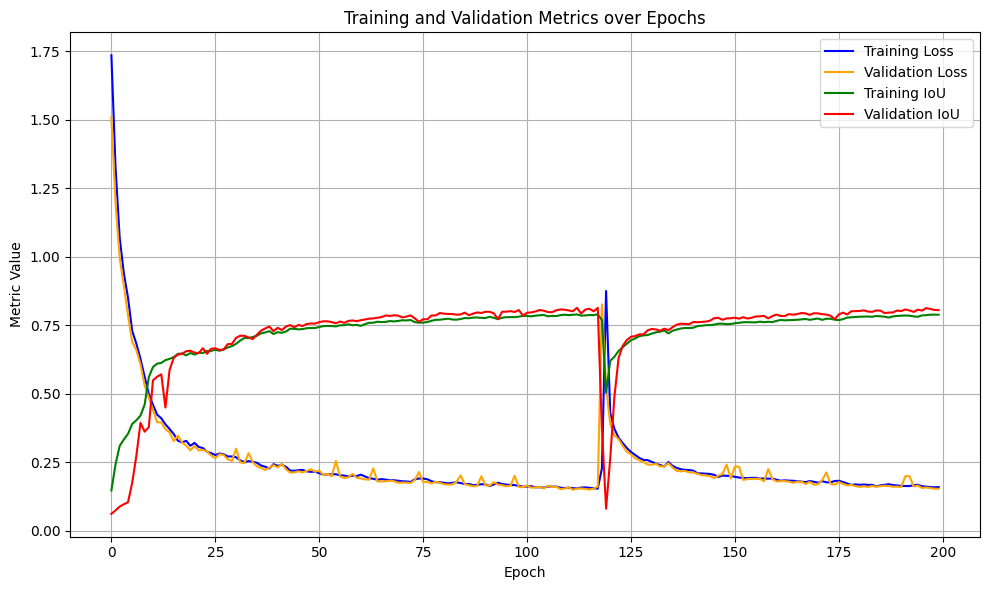

In [25]:
# Step 17: Visualize Training and Validation Metrics
plt.figure(figsize=(10, 6))

# Plotting Training Loss
plt.plot(train_loss_hist, label='Training Loss', color='blue')

# Plotting Validation Loss
plt.plot(val_loss_hist, label='Validation Loss', color='orange')

plt.plot(train_iou_hist, label='Training IoU', color='green')

# Plotting Validation IoU
plt.plot(val_iou_hist, label='Validation IoU', color='red')

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training and Validation Metrics over Epochs')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [26]:
# Step 18: Save Model Weights
torch.save(model.cpu().state_dict(), model_path)

In [28]:
color_encoding = [
                ('a', (0, 0, 0)),    # Black
                ('b', (255, 0, 0)),  # Red
                ('c', (0, 255, 0)),  # Green
                ('d', (0, 0, 255)),  # Blue
                ('e', (255, 255, 0)),  # Yellow
                ('f', (0, 255, 255))   # Cyan
]

num_classes=7

def label_for_cross_entropy(label):
    """
        Convert label image to matrix classes for apply cross entropy loss.
        Return semantic index, label in enumemap of H x W x class
    """
    semantic_map = np.zeros(label.shape[:-1])
    # Fill all value with class 13 - default for all pixels
    semantic_map.fill(num_classes - 1)
    # Fill the pixel with correct class

    for class_index, color_info in enumerate(color_encoding):
        color = color_info[1]
        equality = np.equal(label, color)
        class_map = np.all(equality, axis=-1)
        semantic_map[class_map] = class_index
    return semantic_map

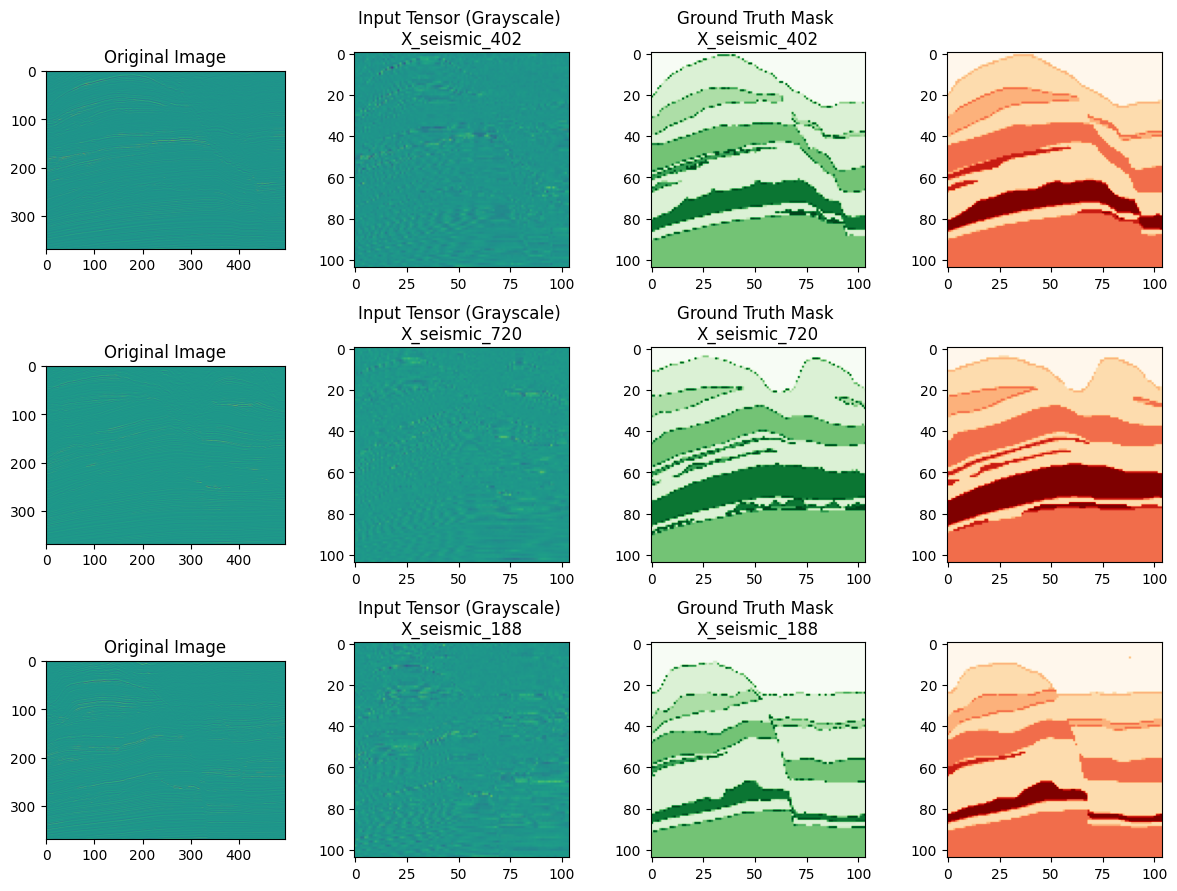

In [32]:
# Step 20: Evaluate Model on Sample Images
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Define the sample image names
names = ['X_seismic_402', 'X_seismic_720', 'X_seismic_188']
names2 = ['X_mask_402', 'X_mask_720', 'X_mask_188']

val_image_path = '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic'
val_mask_path = '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask'

# Load the sample images and masks
images = [Image.open(os.path.join(val_image_path, name+'.png')) for name in names]
images = [i.convert('RGB') for i in images]

masks = [Image.open(os.path.join(val_mask_path, name+'.png')) for name in names2]
masks = [i.convert('RGB') for i in masks]
masks = [np.array(i) for i in masks]
masks = [label_for_cross_entropy(i) for i in masks]
masks = [Image.fromarray(i) for i in masks]

# Apply transformations to convert images to tensors
transforms = T.Compose([T.ToTensor(), T.Resize((104, 104))])
x = torch.stack([transforms(image) for image in images])
y = torch.stack([transforms(mask) for mask in masks])

# Generate predictions using the model
# Assuming 'x' is your input tensor
x = x.to(device)  # Move input tensor to the same device as the model

# Generate predictions using the model
outputs = model(x)
outputs =  outputs.squeeze()

output_temps = outputs 
outputs = np.array(outputs.detach().cpu())

# val_label = val_label.squeeze()
# val_label = np.array(val_label)

# Visualize the sample images, ground truth masks, and model predictions
fig = plt.figure(figsize=(12, 9))
for i in range(len(names)):
    # Plot original image
    ax = fig.add_subplot(3, 4, i*4+1)
    plt.imshow(images[i])
    ax.set_title("Original Image")

    # Plot input tensor
    ax = fig.add_subplot(3, 4, i*4+2)
    # Assuming x is your tensor on a CUDA device (GPU)
    # Move tensor x to CPU and then convert it to a NumPy array
    x_numpy = x[i].squeeze().cpu().numpy()
    
    x_numpy = np.transpose(x_numpy, (1, 2, 0))
    
    ax.imshow(x_numpy.squeeze(), cmap="Greys")
    ax.set_title(f'Input Tensor (Grayscale) \n{names[i]}')

    # Plot ground truth mask
    ax = fig.add_subplot(3, 4, i*4+3)
    ax.imshow(y[i].squeeze(), cmap="Greens")
    ax.set_title(f'Ground Truth Mask \n{names[i]}')
    
    # Plot model prediction
    ax = fig.add_subplot(3, 4, i*4+4)
    # Move tensor from GPU to CPU and then convert it to a NumPy array
    output = outputs[i].squeeze()
    
    # Convert NumPy array to PyTorch tensor
    output_tensor = torch.from_numpy(output)
    
    class_labels = torch.argmax(output_tensor, dim=0)
    class_labels_np = class_labels.cpu().numpy().astype(np.uint8)
    
    ax.imshow(class_labels_np, cmap="OrRd")
#     ax.set_title("Model Prediction\nmIoU: " + str(round(df_sorted[df_sorted['name'] == names[i]]['IoU'].values[0], 3)))

plt.tight_layout()
plt.show()